In [2]:
#Problem A
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import scipy as scipy

#Initial Parameters
hbar = m = 1
eta = 0.4
alpha = .4
N = int(3000 / eta) + 1000
N_tau = int(N * eta) #Vary this parameter. Length of MCMC.
sweep = 2000 #Vary this parameter. Number of MCMC we run.
N_D = 1000 #Vary this parameter. Affects how wide each bin is.
hit = 1.1 #Vary this parameter. Affects acceptance rate.
xmin, xmax = -4 , 4
XMIN = np.sqrt(1 / alpha)
DELTAX = (xmax - xmin) / N_D
omega = np.sqrt(8 * alpha * xmin ** 2)
x = np.linspace(xmin, xmax, N_D + 1)
path = 2 * (np.random.randint(2, size = N_tau) - 0.5) #Intialize path. cold start(all zeros) is what the paper did but maybe try with hot start(random numbers)
calc = np.zeros(N_D) #Array for holding final results.
totalrate = 0 #Acceptance Rate
tracker = []
burn = 0



#Potential
def V(x):
    return alpha * x ** 4 + (-2 * x ** 2) + 1 / alpha

#Lagrangian
def lagrang(left, right):
    first = 0.5 * m * ((right - left) ** 2) / eta
    second = eta * V((left+right)/2)
    return first + second

#Ground State Energy. Based on method from assignment 2.
def He(calc):
    normah = calc / np.sum(calc * DELTAX)
    K = np.real((1 / 2)*np.sum(DELTAX * np.diff(np.sqrt(normah))*np.diff(np.sqrt(normah)) / DELTAX**2))
    Ve = np.sum(normah * V(x[:-1])) * DELTAX
    E_ground = K + Ve
    return (E_ground / 2)
#Monte Carlo Markov Chain Function. path = initial configuration, calc = final configuration.
def MCMC(path, calc):
    global burn
    burn = int(N_tau / 10) #Burn Amount
    global totalrate
    for i in range(N_tau):
        #Takes a random step as long as x1 is between xmin and xmax.
        x1 = (path[i] + np.random.random() * 2 * hit) - hit
        while x1 > xmax or x1 < xmin:
            x1 = (path[i] + np.random.random() * 2 * hit) - hit

        #Calculates change in action from initial step to next step.
        left = path[i - 1]
        if i < N_tau - 1 :
            right = path[i + 1]
        else : 
            path[0] #Fixes the random bump we have been getting in the plot.
        action = lagrang(left, x1) + lagrang(x1, right)
        action -= lagrang(left, path[i]) + lagrang(path[i], right)

        #Accept or Reject.
        if action <= 0:
            path[i] = x1
            totalrate += 1 / N_tau
        else:
            prob = np.exp(-action)
            if np.random.random() < prob:
                path[i] = x1
                totalrate += 1 / N_tau
    data, _ = np.histogram(path[burn:], bins = x)
    calc += data
    tracker.append(np.mean([(i ** 2) / 2 if i != 0 else path[idx - 1] ** 2 for idx, i in enumerate(path)]))

#Expected Distribution
H = np.zeros((N_D + 1, N_D + 1))
for i in range(N_D + 1):
    for j in range(N_D + 1):
        # kinetic part
        H[i, j] = -(0.5 / DELTAX**2) * ((i + 1 == j) - 2 * (i == j) + (i - 1 == j)) 
        # potential part
        H[i, j] += V(x[i]) * (i == j)
        
Es, psis = scipy.sparse.linalg.eigsh(H, k=2, sigma=1.5, which='LM')

E_0 = Es[0]
psi_0 = psis[:, 0]

# normalize the wave functions
psi_0 /= np.sqrt(np.sum(psi_0.conjugate() * psi_0) * DELTAX)
norm = np.abs(psi_0)**2
norm /= np.sum(norm) * DELTAX

#Runs {sweep} MCMC chains and stores results to calc.
for a in tqdm.tqdm(range(sweep)):
    MCMC(path, calc)

print(f"\nτ: {N_tau}\nBurn-in Steps: {burn}\nHit Size: {hit}\nNumber of Sweeps: {sweep}\nAcceptance Rate: {totalrate/sweep}")
print(f"Expected Ground State Energy: {E_0}")
print(f"MCMC Ground State Energy: {He(calc)}")

100%|██████████| 2000/2000 [00:34<00:00, 57.76it/s]


τ: 3400
Burn-in Steps: 340
Hit Size: 1.1
Number of Sweeps: 2000
Acceptance Rate: 0.5286583823589017
Expected Ground State Energy: 1.2344963898591181
MCMC Ground State Energy: 1.3937332205939288


For determining $\tau$, we wanted it to be large enough that most MCMC would stabilize after running the simulations so after testing, we determined that $\tau=3000$ achieved that goal. For determining the initial configuration, we chose to start at hot start because that would generate better results based off of our previous experience. For determining the burn-in steps, we chose it to be $\frac{\tau}{10}$ so that any irrelevant data did not get added to the relevant data. For determining the hit size, we chose a number that would get our acceptance rate close to 0.5 so after testing, we found that at a hit size of 1.1 gave us an acceptance rate of around 0.53. For determining the number of sweeps, we wanted to have a number that was large enough that it would give us an accurate representation of the data but small enough that it would not take too long to run so we chose 2000. We did not encounter any thinning. The most optimal eta was determined with the while loop below.

In [ ]:
# Finding best Eta
expected = np.max(normizle(norm))
mcmc_gen = 0.5
eta = 3.0
N = int(3000 / eta)
N_tau = int(N * eta)
while mcmc_gen < expected:
    eta = eta + 0.001
    N = int(3000 / eta)
    path = np.zeros(N_tau) # reset path
    calc = np.zeros(N_D) #reset calc
    for a in tqdm.tqdm(range(sweep)):
        MCMC(path, calc)
    mcmc_gen = np.max(calc / np.sum(calc * DELTAX))
    print("mcmc ",mcmc_gen)
    print("Expecedt: ",expected)
print("Best Eta: ",eta)

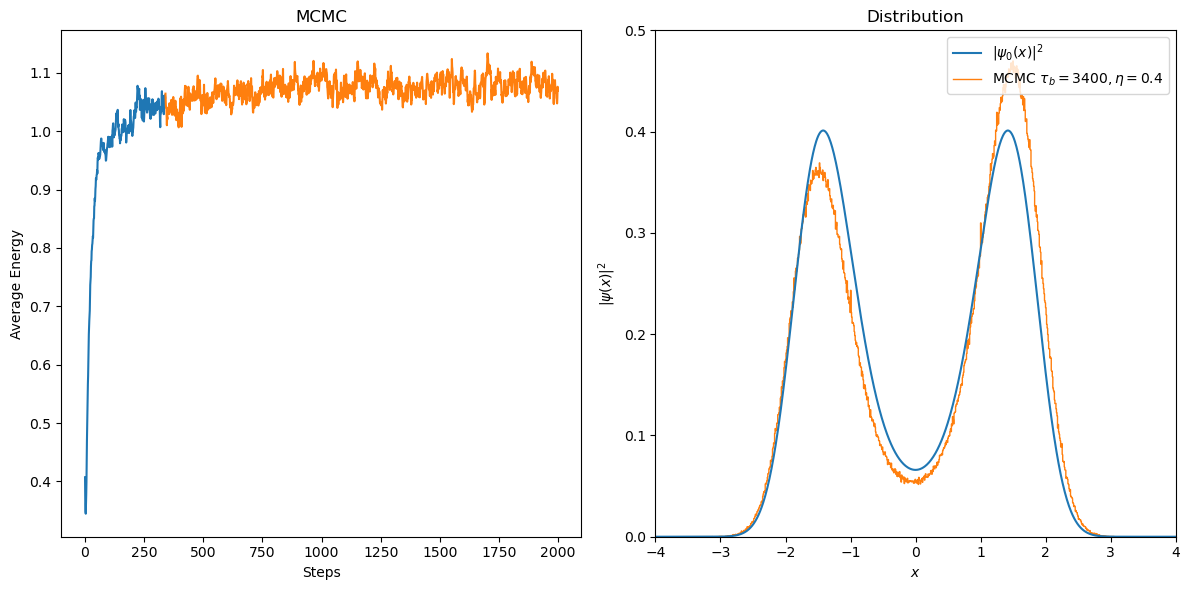

In [3]:
#Problem B
ymin, ymax = 0, 0.5
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[1].plot(x, norm, label=r"$|\psi_0(x)|^2$")
ax[1].stairs(calc / np.sum(calc * DELTAX), x, label=f"MCMC $\\tau_b={N_tau}, \\eta = {eta}$")
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$|\psi(x)|^2$")
ax[1].set_xlim([xmin, xmax])
ax[1].set_ylim([ymin, ymax])
ax[1].legend(loc = 'upper right')
ax[1].set_title('Distribution')


ax[0].plot(range(len(tracker))[:burn], tracker[:burn], label="Burn")
ax[0].plot(range(len(tracker))[burn:], tracker[burn:], label="MCMC Samples")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Average Energy")
ax[0].set_title('MCMC')

plt.tight_layout()
plt.show()

The expected distribution and the MCMC distribution appear very similar to one another when you plot it.

100%|██████████| 2000/2000 [00:05<00:00, 347.22it/s]


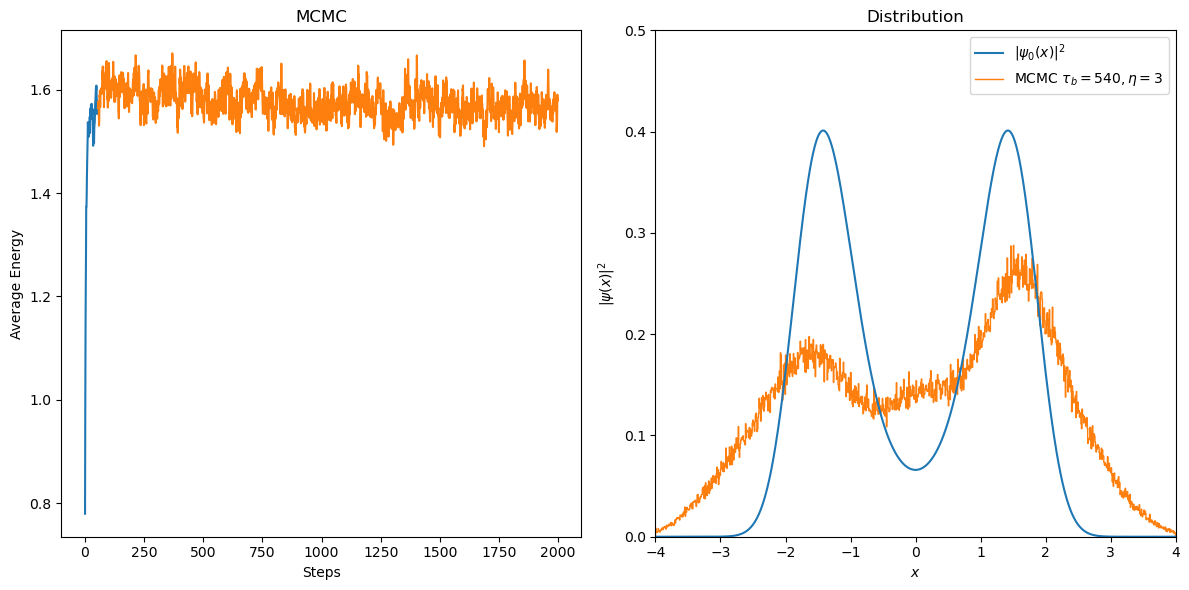

MCMC Ground State Energy: 8.928416379513195
Expected Ground State Energy: 1.2344963898591181


In [5]:
#Problem C
eta = 3
N = 180
N_tau = int(N*eta)
path = 2 * (np.random.randint(2, size = N_tau) - 0.5)
calc = np.zeros(N_D)
tracker = []
for a in tqdm.tqdm(range(sweep)):
    MCMC(path, calc)

ymin, ymax = 0, 0.5
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[1].plot(x, norm, label=r"$|\psi_0(x)|^2$")
ax[1].stairs(calc / np.sum(calc * DELTAX), x, label=f"MCMC $\\tau_b={N_tau}, \\eta = {eta}$")
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$|\psi(x)|^2$")
ax[1].set_xlim([xmin, xmax])
ax[1].set_ylim([ymin, ymax])
ax[1].legend(loc = 'upper right')
ax[1].set_title('Distribution')


ax[0].plot(range(len(tracker))[:burn], tracker[:burn], label="Burn")
ax[0].plot(range(len(tracker))[burn:], tracker[burn:], label="MCMC Samples")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Average Energy")
ax[0].set_title('MCMC')

plt.tight_layout()
plt.show()
print(f"MCMC Ground State Energy: {He(calc)}")
print(f"Expected Ground State Energy: {E_0}")

The probability distribution of the MCMC with a smaller  τb  is much more rough and inconsistent than a larger  τb  value. The value for ground state energy is also much different than the original MCMC ground state. The expected probability distribution is plotted on the same graph. This means that the chains are not long enough and they do not have enough time to settle to a consistent value. Outliers affect the data much more as a result of this.

# Extra Code used for Project

100%|██████████| 4000/4000 [01:10<00:00, 56.47it/s]


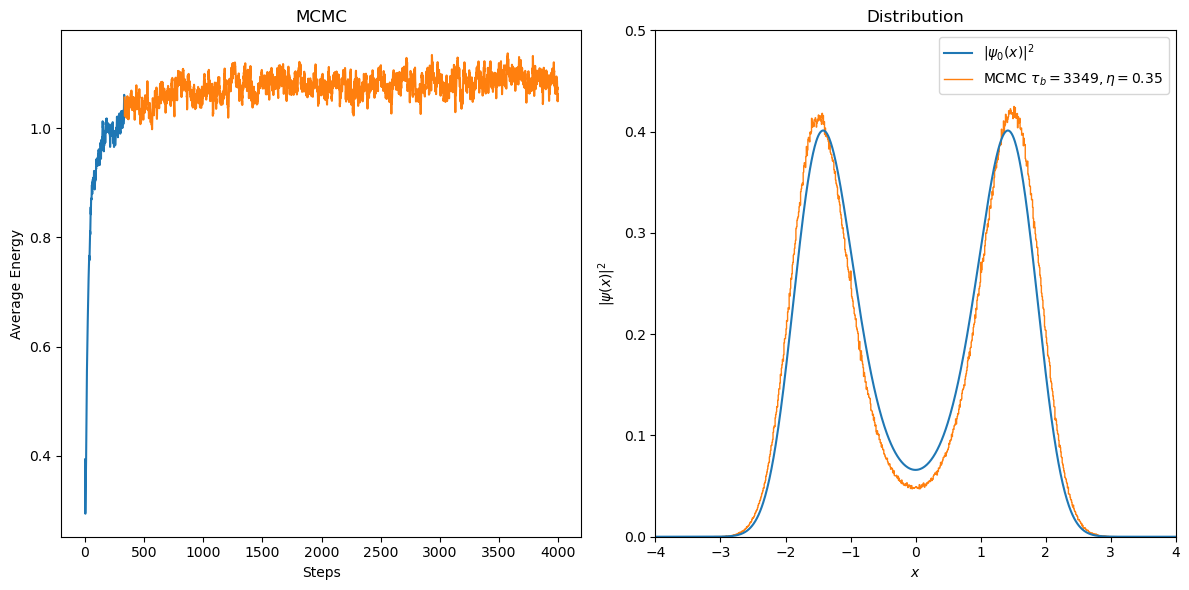

MCMC Ground State Energy: 1.0713002592893175
Expected Ground State Energy: 1.2344963898591181


In [17]:
## Best Looking Graph
eta = .35
N = int(3000 / eta) + 1000
N_tau = int(N * eta)
hit = 1.1
path = 2 * (np.random.randint(2, size = N_tau) - 0.5)
calc = np.zeros(N_D)
tracker = []
sweep = 2000
totalrate = 0
for a in tqdm.tqdm(range(sweep * 2)):
    MCMC(path, calc)

ymin, ymax = 0, 0.5
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[1].plot(x, norm, label=r"$|\psi_0(x)|^2$")
ax[1].stairs(calc / np.sum(calc * DELTAX), x, label=f"MCMC $\\tau_b={N_tau}, \\eta = {eta}$")
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$|\psi(x)|^2$")
ax[1].set_xlim([xmin, xmax])
ax[1].set_ylim([ymin, ymax])
ax[1].legend(loc = 'upper right')
ax[1].set_title('Distribution')


ax[0].plot(range(len(tracker))[:burn], tracker[:burn], label="Burn")
ax[0].plot(range(len(tracker))[burn:], tracker[burn:], label="MCMC Samples")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Average Energy")
ax[0].set_title('MCMC')


plt.tight_layout()
plt.show()
print(f"MCMC Ground State Energy: {He(calc)}")
print(f"Expected Ground State Energy: {E_0}")

100%|██████████| 2000/2000 [00:10<00:00, 187.04it/s]


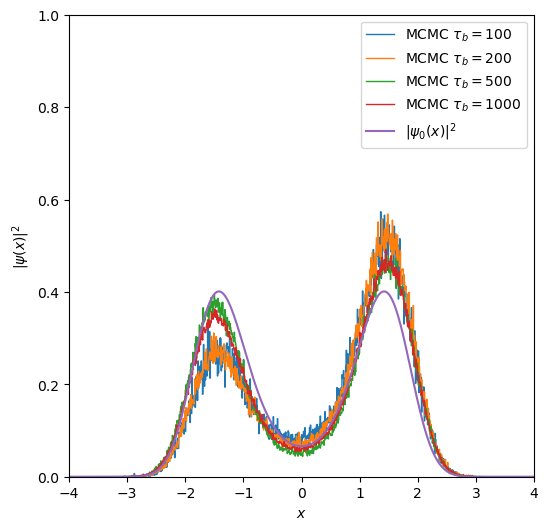

In [7]:
#Tau Comparisons
taus = [100, 200, 500, 1000]
taumcmc = []
sweep = 2000
for val in taus:
    N_tau = val
    path = 2 * (np.random.randint(2, size = N_tau) - 0.5)
    calc = np.zeros(N_D)
    for a in tqdm.tqdm(range(sweep)):
        MCMC(path, calc)
    taumcmc.append(calc)

plt.figure(figsize=(6, 6))
for i in range(4):
    plt.stairs(taumcmc[i] / np.sum(taumcmc[i] * DELTAX), x, label=f"MCMC $\\tau_b={taus[i]}$")
plt.plot(x, norm, label=r"$|\psi_0(x)|^2$")
plt.xlabel(r"$x$")
plt.ylabel(r"$|\psi(x)|^2$")
plt.xlim([xmin, xmax])
plt.ylim([ymin, 1])
plt.legend(loc = 'upper right')
plt.show()
#Important Observations: Increasing tau significantly decreases processing speed at a 1 to 1 ratio. Increasing tau also smooths out and evens the two peaks of the distribution plot.

100%|██████████| 10000/10000 [02:55<00:00, 56.96it/s]


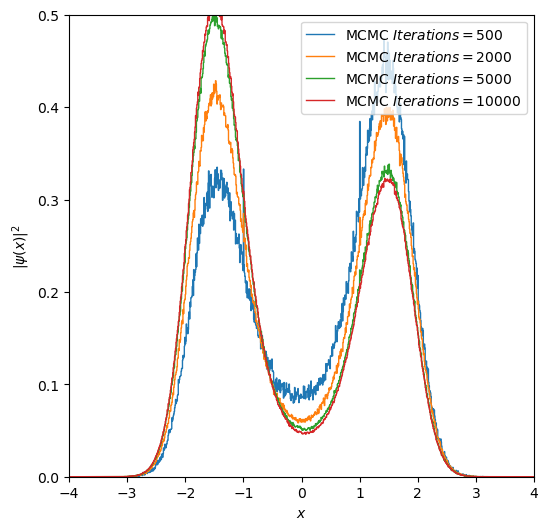

In [8]:
#Sweep Comparisons (Number of MCMC that is simulated)
sweeps = [500, 2000, 5000, 10000]
sweepmcmc = []
N_tau = int(N * eta)
for val in sweeps:
    sweep = val
    path = 2 * (np.random.randint(2, size = N_tau) - 0.5)
    calc = np.zeros(N_D)
    for a in tqdm.tqdm(range(sweep)):
        MCMC(path, calc)
    sweepmcmc.append(calc)

plt.figure(figsize=(6, 6))
for i in range(4):
    plt.stairs(sweepmcmc[i] / np.sum(sweepmcmc[i] * DELTAX), x, label=f"MCMC $Iterations={sweeps[i]}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$|\psi(x)|^2$")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.legend(loc = 'upper right')
plt.show()
#Important Observations: Increasing sweep significantly increases run time at a 1 to 1 ratio. Increasing sweep gives less variation to the results from one simulation to another.

100%|██████████| 2000/2000 [08:22<00:00,  3.98it/s]


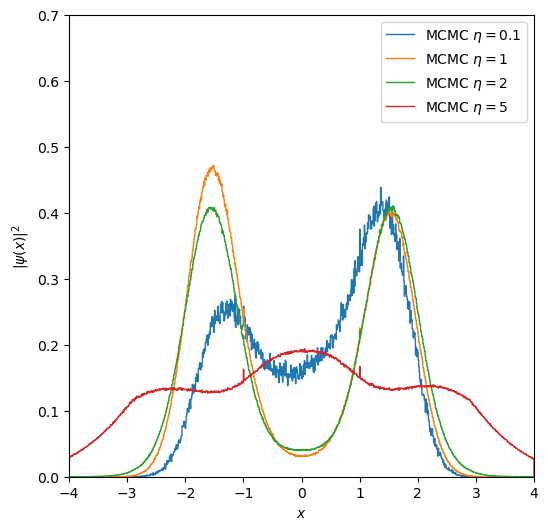

In [9]:
#Eta Comparisons (Number of MCMC that is simulated)
etas = [0.1, 1, 2, 5]
etamcmc = []
sweep = 2000
for val in etas:
    eta = val
    N_tau = int(N * eta)
    path = 2 * (np.random.randint(2, size = N_tau) - 0.5)
    calc = np.zeros(N_D)
    for a in tqdm.tqdm(range(sweep)):
        MCMC(path, calc)
    etamcmc.append(calc)

plt.figure(figsize=(6, 6))
for i in range(4):
    plt.stairs(etamcmc[i] / np.sum(etamcmc[i] * DELTAX), x, label=f"MCMC $\\eta={etas[i]}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$|\psi(x)|^2$")
plt.xlim([xmin, xmax])
plt.ylim([ymin, .7])
plt.legend(loc = 'upper right')
plt.show()
#Important Observations: Increasing eta significantly decreases processing speed at a 1 to 1 ratio. Eta has a significant impact on the shape of the graph, espcially the two peaks of the distribution.

100%|██████████| 2000/2000 [00:35<00:00, 56.91it/s]


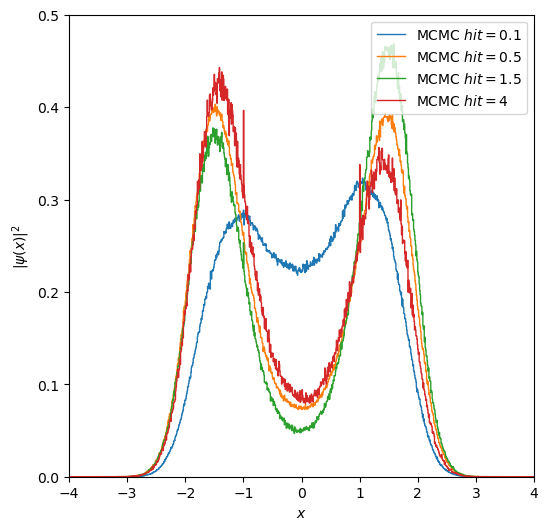

In [10]:
#Hit Comparisons (Affects Acceptance Rate)
hits = [.1, .5, 1.5, 4]
hitmcmc = []
eta = 0.4
N = int(3000 / eta) + 1000
N_tau = int(N * eta)
for val in hits:
    hit = val
    path = 2 * (np.random.randint(2, size = N_tau) - 0.5)
    calc = np.zeros(N_D)
    for a in tqdm.tqdm(range(sweep)):
        MCMC(path, calc)
    hitmcmc.append(calc)

plt.figure(figsize=(6, 6))
for i in range(4):
    plt.stairs(hitmcmc[i] / np.sum(hitmcmc[i] * DELTAX), x, label=f"MCMC $hit={hits[i]}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$|\psi(x)|^2$")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.legend(loc = 'upper right')
plt.show()
#Important Observations: Changing hit size has no impact on run time. Hit size has a significant impact on the shape of the graph, especially the shape of the center of the graph.

100%|██████████| 2000/2000 [00:31<00:00, 64.23it/s]


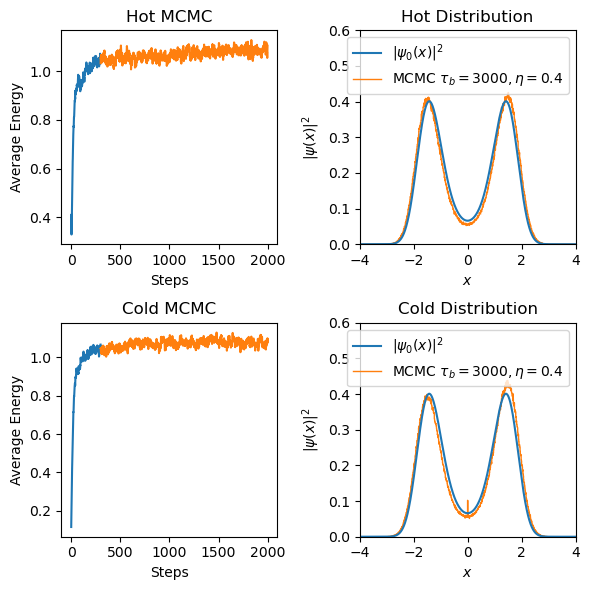

In [15]:
#Hot Start
eta = 0.4
N = int(3000 / eta)
N_tau = int(N * eta)
hit = 1.1
starts = [2 * (np.random.randint(2, size = N_tau) - 0.5), np.zeros(N_tau)]
pathmcmc = []
trackers = []
for init in starts:
    path = init
    calc = np.zeros(N_D)
    tracker = []
    for a in tqdm.tqdm(range(sweep)):
        MCMC(path, calc)
    pathmcmc.append(calc)
    trackers.append(tracker)

ymin, ymax = 0, 0.6
fig, ax = plt.subplots(2, 2, figsize = (6, 6))

for i in range(2):
    ax[i, 1].plot(x, norm, label=r"$|\psi_0(x)|^2$")
    ax[i, 1].stairs(pathmcmc[i] / np.sum(pathmcmc[i] * DELTAX), x, label=f"MCMC $\\tau_b={N_tau}, \\eta = {eta}$")
    ax[i, 1].set_xlabel(r"$x$")
    ax[i, 1].set_ylabel(r"$|\psi(x)|^2$")
    ax[i, 1].set_xlim([xmin, xmax])
    ax[i, 1].set_ylim([ymin, ymax])
    ax[i, 1].legend(loc = 'upper right')


    ax[i, 0].plot(range(len(trackers[i]))[:burn], trackers[i][:burn], label="Burn")
    ax[i, 0].plot(range(len(trackers[i]))[burn:], trackers[i][burn:], label="MCMC Samples")
    ax[i, 0].set_xlabel("Steps")
    ax[i, 0].set_ylabel("Average Energy")

ax[1, 0].set_title('Cold MCMC')
ax[0, 0].set_title('Hot MCMC')
ax[0, 1].set_title('Hot Distribution')
ax[1, 1].set_title('Cold Distribution')
plt.tight_layout()
plt.show()
#Important Observations: Hot Start has no impact on run time. No visible difference on data.

100%|██████████| 2000/2000 [00:30<00:00, 65.65it/s]


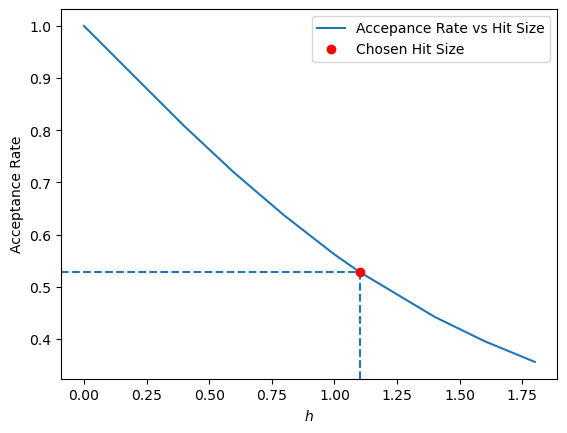

In [12]:
# Finding Best H
eta = 0.4
hit_list = [0,.2,.4,.6,.8,1,1.1, 1.4, 1.6, 1.8]
accrate = []
for i in range(len(hit_list)):
    hit = hit_list[i]
    totalrate = 0
    path = 2 * (np.random.randint(2, size = N_tau) - 0.5) #Intialize path. cold start(all zeros) is what the paper did but maybe try with hot start(random numbers)
    calc = np.zeros(N_D) #Array for holding final results.
    for a in tqdm.tqdm(range(sweep)):
        MCMC(path, calc)
    accrate.append(totalrate/sweep)

plt.plot(hit_list,accrate, label="Accepance Rate vs Hit Size")
plt.xlabel(r"$h$")
plt.ylabel("Acceptance Rate")
plt.axvline(x = 1.1, ymax = .3,linestyle = '--')
plt.axhline(y = accrate[6], xmax=.6, linestyle = '--')
plt.plot(1.1,accrate[6],'ro',label="Chosen Hit Size")
plt.legend()
plt.show()

$\textbf{\textit{Bibliography}}$

[1]  S. Mittal, M. J. Westbroek, P. R. King, and D. D. Vvedensky, “Path integral Monte Carlo method for
the quantum anharmonic oscillator”, Eur. J. Phys. 41, 055401 (2020). https://iopscience.iop.org/article/10.1088/1361-6404/ab9a66/pdf

[2] R. Rodgers and L. Raes, Monte Carlo simulations of harmonic and anharmonic oscillators in discrete Eu-
clidean time, DESY Summer Student Programme (2014). https://www-zeuthen.desy.de/students/2014/reports/RodgersRaes.pdf

[3] Foreman-Mackey, Daniel, et al. ‘Emcee: The MCMC Hammer’. Publications of the Astronomical Society of the Pacific, vol. 125, no. 925, IOP Publishing, Mar. 2013, pp. 306–312, https://iopscience.iop.org/article/10.1086/670067.
